In [1]:
# use python 2 and stanhelper-0.8

In [2]:
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=60)

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('ggplot')
import itertools

from IPython.display import display

import stanhelper

In [3]:
# # LOAD AND PROCESS DATA (or read from PRE-PROCESSED files)

# path_to_data = '/Users/alpkucukelbir/files/data/movielens/ml-latest-small/'

# # ratings
# ratings = pd.read_csv(path_to_data+'ratings.csv', sep=',', index_col='userId')
# ratings['rating'] = ratings['rating'].apply(np.ceil).astype('int')
# del ratings['timestamp']

# # movie names
# movies = pd.read_csv(path_to_data+'movies.csv', sep=',', index_col='movieId')
# movies = movies.reset_index()
# movies.index = np.arange(1, len(movies) + 1)
# movies['oldMovieId'] = movies['movieId']
# del movies['movieId']
# movies.index.name = 'movieId'

# ratings['oldMovieId'] = ratings['movieId']
# ratings['newMovieId'] = ratings['oldMovieId'].apply(lambda x: movies.index[movies['oldMovieId']==x].values[0])
# del ratings['movieId']
# ratings['movieId'] = ratings['newMovieId']
# del ratings['newMovieId']
# ratings = ratings[['movieId','rating','oldMovieId']]

# ratings.to_pickle('ratings_reindexed.pickle')
# movies.to_pickle('movies_reindexed.pickle')

ratings = pd.read_pickle('ratings_reindexed.pickle')
movies = pd.read_pickle('movies_reindexed.pickle')

# ratings = pd.read_pickle('ratings_1M_reindexed.pickle')
# movies = pd.read_pickle('movies_1M_reindexed.pickle')

# Data has ratings from 1 to 5. Threshold at 1.
ratings['rating'] = 1

In [4]:
# DEFINE ALL OF THE PARAMETERS IN THIS SCRIPT HERE

# internal dimension of PF model
K = 10

# exponential prior
lambd = 1/1e3

# training/testing split
test_ratio = 0.2 # this is the ratio of users that go into the testing dataset

# "smoothness" parameter to the Gamma initialization for Stan
initprm = 1e2

In [5]:
# SUBSET THE DATA (optional)

# number of users
U = ratings.index.max()
ratings_subset = ratings[ratings.index <= U] # pick the first U users 

# number of items
I = 1000 #ratings_subset['movieId'].max()
ratings_subset = ratings_subset[(ratings_subset['movieId'] <= I)]

# after this subsetting, some users have < 20 ratings
# toss those users away
ratings_subset = ratings_subset.ix[ratings_subset.groupby(ratings_subset.index).sum()['rating'] >= 20]

# reindex the users and update U
old_index = ratings_subset.index.unique()
new_index = np.arange(1, np.size(old_index)+1)
ratings_subset.index = ratings_subset.index.map(lambda x: new_index[old_index==x][0])
U = ratings_subset.index.max()

/Users/yixinwang/py2/lib/python2.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [6]:
# OPTIONAL: CORRUPT DATASET

# Users with more than 100 ratings
users_with_lots_of_ratings = ratings_subset.index.unique()[ 
    (ratings_subset.groupby(ratings_subset.index).sum()['rating']>150).values ]

# Number of users in training dataset to corrupt
top_R_users_to_corrupt      = 20

# Ratio of ratings to randomly resample from other movies
ratio_of_ratings_to_corrupt = 1

for u in users_with_lots_of_ratings[0:top_R_users_to_corrupt]:
    number_of_movies_to_corrupt = int(np.floor(ratio_of_ratings_to_corrupt*ratings_subset.xs(u).shape[0]))

    this_users_movies      = ratings_subset.xs(u)['movieId'].values
    not_this_users_movies  = np.setdiff1d(np.arange(I)+1, this_users_movies)
    randomly_chosen_movies = np.random.choice(not_this_users_movies, 
                                              size=number_of_movies_to_corrupt, 
                                              replace=False)
    this_users_movies[0:number_of_movies_to_corrupt] = randomly_chosen_movies
    ratings_subset.xs(u)['movieId'] = this_users_movies
# print ratings_subset.groupby(ratings_subset.index).sum()['rating']

In [7]:
users_with_lots_of_ratings = ratings_subset.index.unique()[ 
    (ratings_subset.groupby(ratings_subset.index).sum()['rating']>150).values ]
print(users_with_lots_of_ratings[0:top_R_users_to_corrupt])

Int64Index([ 16,  35,  49,  59,  61,  95,  98, 102, 111, 113, 119, 139, 141,
            145, 153, 160, 182, 192, 197, 228],
           dtype='int64', name=u'userId')


In [8]:
# TRAINING/TESTING SPLIT

# number of useres in train and test sets
Utr = int(np.floor((1-test_ratio)*U))
Ute = U - Utr

# get the training dataset
ratings_train = ratings_subset[ratings_subset.index <= Utr]

# get the testing dataset (requires reindexing)
ratings_test  = ratings_subset[ratings_subset.index > Utr]
old_index = ratings_test.index.unique()
new_index = np.arange(1, np.size(old_index)+1)
ratings_test.index = ratings_test.index.map(lambda x: new_index[old_index==x][0])

print('result of training/testing splitting')
print('training users: '+str(Utr))
print('testing users: '+str(Ute))

result of training/testing splitting
training users: 338
testing users: 85


In [9]:
# convert datasets into numpy
data_ind = ratings_train.sort_index().index.values
data_rat = ratings_train.sort_index().values
data_train = np.array(np.concatenate((np.atleast_2d(data_ind).T, data_rat), axis=1), dtype='int')

data_ind = ratings_test.sort_index().index.values
data_rat = ratings_test.sort_index().values
data_test = np.array(np.concatenate((np.atleast_2d(data_ind).T, data_rat), axis=1), dtype='int')

print('size of training dataset')
print('number of nonzero measurements: '+str(data_train.shape[0]))
print('number of parameters in stan: '+str((Utr*K)+(I*K)))

size of training dataset
number of nonzero measurements: 22950
number of parameters in stan: 13380


In [10]:
# write training dataset to file
train_dict = {}
train_dict['U'] = Utr;
train_dict['I'] = I;
train_dict['K'] = K;
train_dict['number_entries'] = data_train.shape[0]
train_dict['user_index'] = data_train[:,0]
train_dict['item_index'] = data_train[:,1]
train_dict['rating'] = data_train[:,2]
train_dict['lambda'] = lambd
train_dict['beta_a'] = 200
train_dict['beta_b'] = 1
stanhelper.stan_rdump(train_dict, 'train_dict.data.R')

In [11]:
# write initialization to file
train_dict_init = {}
train_dict_init['theta'] = np.random.gamma(initprm,scale=1.0/initprm, size=(Utr,K))
train_dict_init['beta'] = np.random.gamma(initprm,scale=1.0/initprm, size=(I,K))
train_dict_init['w'] = [0.99] * Utr
stanhelper.stan_rdump(train_dict_init, 'train_dict_init.data.R')

In [12]:
# # RUN STAN MAP OPTIMIZATION for a few iterations to get SOME INITIALIZATION

# # DO THIS FROM THE COMMAND LINE AND WAIT FOR RESULTS

execution_string  = './expp_sparse_w_beta optimize iter=10 '
execution_string += 'data file=train_dict.data.R init=train_dict_init.data.R output file=train_map_output.csv'
print execution_string

./expp_sparse_w_beta optimize iter=10 data file=train_dict.data.R init=train_dict_init.data.R output file=train_map_output.csv


In [13]:
! ./expp_sparse_w_beta optimize iter=10 data file=train_dict.data.R init=train_dict_init.data.R output file=train_map_output.csv

method = optimize
  optimize
    algorithm = lbfgs (Default)
      lbfgs
        init_alpha = 0.001 (Default)
        tol_obj = 9.9999999999999998e-13 (Default)
        tol_rel_obj = 10000 (Default)
        tol_grad = 1e-08 (Default)
        tol_rel_grad = 10000000 (Default)
        tol_param = 1e-08 (Default)
        history_size = 5 (Default)
    iter = 10
    save_iterations = 0 (Default)
id = 0 (Default)
data
  file = train_dict.data.R
init = train_dict_init.data.R
random
  seed = 667005424
output
  file = train_map_output.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Initial log joint probability = -3.29161e+06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      10      -63754.1       26.2147        545.14       2.288      0.2288       13   
Optimization terminated normally: 
  Maximum number of iterations hit, may not be at an optima


In [14]:
train_map_results = stanhelper.stan_read_csv('train_map_output.csv')
train_map_init = {}
train_map_init['theta'] = train_map_results['theta']
train_map_init['beta']  = train_map_results['beta']
stanhelper.stan_rdump(train_map_init, 'train_map_init.data.R')

In [15]:
## RUN STAN VARIATIONAL INFERENCE 

# DO THIS FROM THE COMMAND LINE AND WAIT FOR RESULTS

execution_string  = './expp_sparse_w_beta variational iter=30000 adapt engaged=0 eta=0.25 tol_rel_obj=1e-2 output_samples=1 '
execution_string += 'data file=train_dict.data.R init=train_dict_init.data.R output file=train_output.csv'
print execution_string

./expp_sparse_w_beta variational iter=30000 adapt engaged=0 eta=0.25 tol_rel_obj=1e-2 output_samples=1 data file=train_dict.data.R init=train_dict_init.data.R output file=train_output.csv


In [16]:
! ./expp_sparse_w_beta variational iter=30000 adapt engaged=0 eta=0.25 tol_rel_obj=1e-2 output_samples=1 data file=train_dict.data.R init=train_dict_init.data.R output file=train_output.csv

method = variational
  variational
    algorithm = meanfield (Default)
      meanfield
    iter = 30000
    grad_samples = 1 (Default)
    elbo_samples = 100 (Default)
    eta = 0.25
    adapt
      engaged = 0
      iter = 50 (Default)
    tol_rel_obj = 0.01 (Default)
    eval_elbo = 100 (Default)
    output_samples = 1
id = 0 (Default)
data
  file = train_dict.data.R
init = train_dict_init.data.R
random
  seed = 667006625
output
  file = train_output.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

------------------------------------------------------------
EXPERIMENTAL ALGORITHM:
  This procedure has not been thoroughly tested and may be unstable
  or buggy. The interface is subject to change.
------------------------------------------------------------



Gradient evaluation took 0.059421 seconds
1000 transitions using 10 leapfrog steps per transition would take 594.21 seconds.
Adjust your expectations accordingly!


Begin stochastic gradient ascent.
  iter           

In [17]:
train_results = stanhelper.stan_read_csv('train_output.csv')

297.557402
(338,)
Int64Index([ 16,  35,  49,  59,  61,  95,  98, 102, 111, 113, 119, 139, 141,
            145, 153, 160, 182, 192, 197, 228, 241, 254, 284, 285, 289, 295,
            298, 302, 347, 352, 356, 363, 365, 383, 385, 395, 423],
           dtype='int64', name=u'userId')


(array([  3.,   1.,   3.,   6.,   8.,  13.,  15.,  15.,
         17., 238.]), array([0.259, 0.333, 0.406, 0.48 , 0.554, 0.627, 0.701,
        0.774, 0.848, 0.921, 0.995]), <a list of 10 Patch objects>)

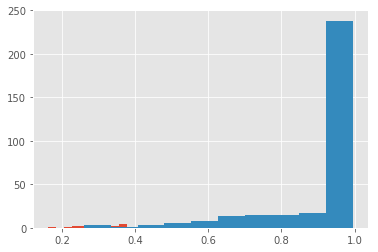

In [18]:
w = train_results['mean_pars']['w']
print(np.sum(train_results['mean_pars']['w']))
print(train_results['mean_pars']['w'].shape)
print(users_with_lots_of_ratings)


crpt_wt = w[users_with_lots_of_ratings[0:(top_R_users_to_corrupt-1)]-1]
uncrpt_wt = w[np.setdiff1d(np.arange(Utr), users_with_lots_of_ratings[0:(top_R_users_to_corrupt-1)]-1)]
plt.hist(crpt_wt)
plt.hist(uncrpt_wt)


{'boxes': [<matplotlib.lines.Line2D at 0x1101e9a50>],
 'caps': [<matplotlib.lines.Line2D at 0x1101f2650>,
 'fliers': [<matplotlib.lines.Line2D at 0x1101f2e10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1101f2dd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1101e9e90>,
  <matplotlib.lines.Line2D at 0x1101e9ed0>]}

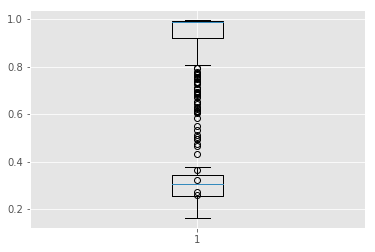

In [19]:
plt.boxplot(crpt_wt)
plt.boxplot(uncrpt_wt)